In [95]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from WallWorld import WallWorld
from DqnAgentNewDims import DqnAgentNewDims, neural_network
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from tensorflow.keras.datasets import mnist

if __name__ == "__main__":

    # Config
    max_steps=500_000

    # WallWorld
    render_mode=None
    size=7
    agentSpawn = None
    maxSteps=200
    stepLoss=0
    chestSpawnCoordinates=np.array([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6],
                                    [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6],
                                    [2, 0], [2, 1], [2, 2],         [2, 4], [2, 5], [2, 6]])
    wallCoordinates=      np.array([[3, 0], [3, 1], [3, 2],         [3, 4], [3, 5], [3, 6],])
    agentSpawnCoordinates=np.array([[4, 0],                                         [4, 6],
                                    [5, 0],                                         [5, 6],
                                    [6, 0],                                         [6, 6]])
    randomWalls=0
    redChestCoordinates=None
    greenChestCoordinates=None
    keyCoordinates=None
    randomredChests=1
    randomgreenChests=1
    randomkeys=0
    redChestReward=-1 # Don't change this
    greenChestReward=1 # Don't change this
    # Explaination:
    # terminated with 1 reward ---> green chest: 1
    # terminated with 0 reward ---> red chest:  -1
    # truncated                 --> no chest:    0
    
    # Agent
    batch_size=64
    lr=0.001
    gamma=0.95
    epsilon_start=1
    epsilon_min=0.05
    epsilon_decay=200_000 # 50_000 at 3000 episodes
    tau=0.0005 # Was 0.005
    replayBuffer=100_000

    env = WallWorld(render_mode=None,
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)
    observation, _ = env.reset()
    agent = DqnAgentNewDims(env.action_space, observation,
        batch_size=batch_size,
        lr=lr,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        tau=tau,
        replayBuffer=replayBuffer)
    
    maxSteps = 30 #????
    show_env = WallWorld(render_mode="human",
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates,
                    newDims=True)

    modelNames = ["r00_g10_1500k",
              "r01_g10_1500k",
              "r02_g10_1500k",
              "r03_g10_1500k",
              "r04_g10_1500k",
              "r05_g10_1500k",
              "r06_g10_1500k",
              "r07_g10_1500k",
              "r08_g10_1500k",
              "r09_g10_1500k",
              "r10_g00_1500k",
              "r10_g01_1500k",
              "r10_g02_1500k",
              "r10_g03_1500k",
              "r10_g04_1500k",
              "r10_g05_1500k",
              "r10_g06_1500k",
              "r10_g07_1500k",
              "r10_g08_1500k",
              "r10_g09_1500k",
              "r10_g10_1500k"]

In [96]:
#Mnist model

# observation to use the same structure as the dqnagent
observation = np.random.rand(1, 28, 28).astype(np.float32)
action_space_n = 10

mnistModel = neural_network(
    action_space_n=action_space_n,
    observation=observation)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:6000]
y_train = y_train[:6000]

x_train = x_train.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, axis=1)# (N, 1, 28, 28)
#x_train = np.repeat(x_train, 3, axis=1) # (N, 3, 28, 28)
y_train = y_train.astype(np.int64)
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)

x_test = x_test.astype(np.float32) / 255.0
x_test = np.expand_dims(x_test, axis=1)# (N, 1, 28, 28)
#x_test = np.repeat(x_test, 3, axis=1) # (N, 3, 28, 28)
y_test = y_test.astype(np.int64)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

# Define Dataset
class MNIST3ChannelDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create DataLoader
train_dataset = MNIST3ChannelDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


"""
num_epochs = 10
mnistModel.train()

for epoch in range(num_epochs):
    for batch_obs, batch_labels in dataloader:
        # Forward pass
        outputs = mnistModel(batch_obs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

torch.save(mnistModel.state_dict(), "C:/Projects/public/XAI_Master/models/mnistModel_1d.pth")
"""
"""
Epoch 1/10, Loss: 0.1962
Epoch 2/10, Loss: 0.0480
Epoch 3/10, Loss: 0.0669
Epoch 4/10, Loss: 0.0060
Epoch 5/10, Loss: 0.0151
Epoch 6/10, Loss: 0.0005
Epoch 7/10, Loss: 0.0077
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0001"""

print(mnistModel)

neural_network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=25088, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Test Accuracy: 9.7900%
Model loaded: C:/Projects/public/XAI_Master/models/mnistModel_1d.pth
Layer: 1
Action index: 9


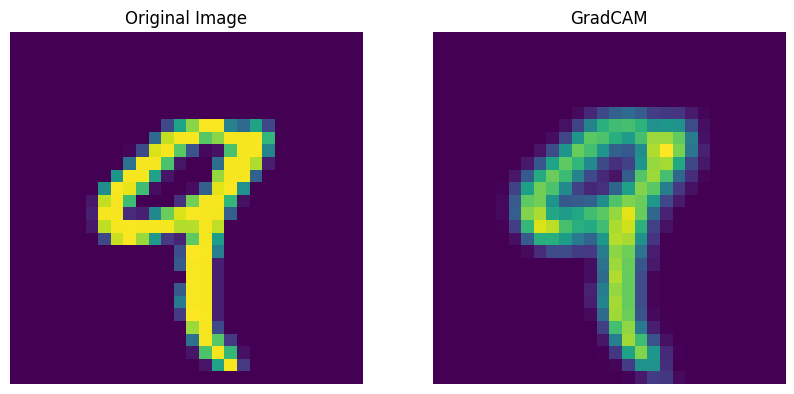

Layer: 2
Action index: 9


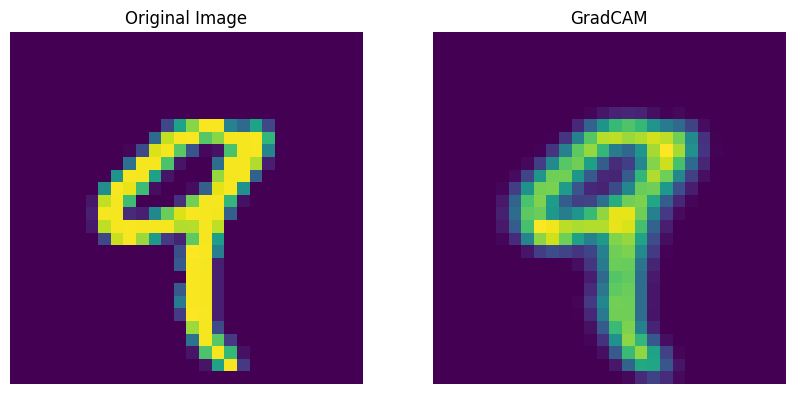

Layer: 3
Action index: 9


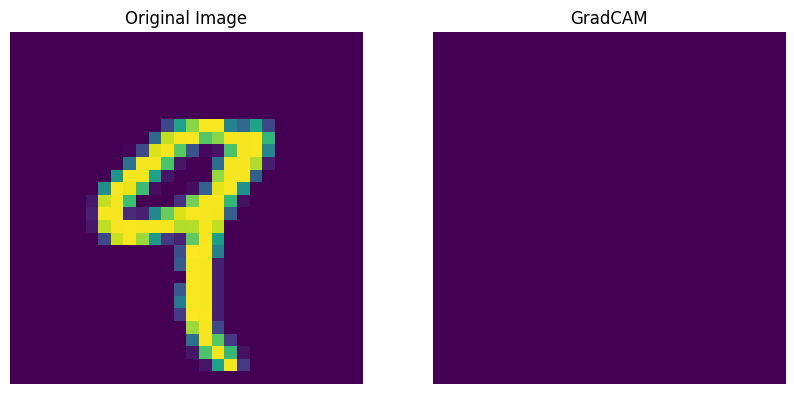

In [97]:
path = "C:/Projects/public/XAI_Master/models/mnistModel_1d.pth"

mnistModel.eval()
with torch.no_grad():
    test_outputs = mnistModel(x_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100
    print(f"Test Accuracy: {accuracy:.4f}%")

mnistModel.load_state_dict(torch.load(path))
mnistModel.eval()
print(f"Model loaded: {path}")

dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

layers = (mnistModel.conv1, mnistModel.conv2, mnistModel.conv3)

for layer, counter in zip(layers, range(len(layers))):
    print(f"Layer: {counter+1}")

    state = dataloader.dataset[4][0].unsqueeze(0) # Change picture here
    actions = mnistModel(state)
    target_layer = mnistModel.conv3
    target_layer = layer
    action_idx = torch.argmax(actions, dim=1).item()
    targets = [ClassifierOutputTarget(action_idx)]
    print(f"Action index: {action_idx}")



    # Create a GradCAM object with the agent's policy network and target layer
    with GradCAM(model=mnistModel, target_layers=[target_layer]) as cam:
        # Generate the CAM
        grayscale_cam = cam(input_tensor=state, targets=targets)
        grayscale_cam = grayscale_cam[0, :]#only one image in the batch
        original_img = state[0].permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, interpolation='nearest')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_cam, interpolation=None)
    plt.title("GradCAM")
    plt.axis('off')
    plt.show()




In [98]:
class mnist_neural_network(nn.Module):
    def __init__(self):
        super(neural_network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: [batch, 32, 13, 13]
        x = self.pool(F.relu(self.conv2(x)))  # Output: [batch, 64, 5, 5]
        x = x.view(-1, 64 * 5 * 5)            # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


mnistSimpleModel = neural_network(
    action_space_n=action_space_n,
    observation=observation)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistSimpleModel.parameters(), lr=0.001)

"""
num_epochs = 10
mnistSimpleModel.train()

for epoch in range(num_epochs):
    for batch_obs, batch_labels in dataloader:
        # Forward pass
        outputs = mnistSimpleModel(batch_obs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

torch.save(mnistModel.state_dict(), "C:/Projects/public/XAI_Master/models/mnistSimpleModel_1d.pth")

"""

"""
Epoch 1/10, Loss: 0.2876
Epoch 2/10, Loss: 0.0938
Epoch 3/10, Loss: 0.0809
Epoch 4/10, Loss: 0.0981
Epoch 5/10, Loss: 0.0199
Epoch 6/10, Loss: 0.0839
Epoch 7/10, Loss: 0.0080
Epoch 8/10, Loss: 0.0061
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0018
"""

'\nEpoch 1/10, Loss: 0.2876\nEpoch 2/10, Loss: 0.0938\nEpoch 3/10, Loss: 0.0809\nEpoch 4/10, Loss: 0.0981\nEpoch 5/10, Loss: 0.0199\nEpoch 6/10, Loss: 0.0839\nEpoch 7/10, Loss: 0.0080\nEpoch 8/10, Loss: 0.0061\nEpoch 9/10, Loss: 0.0003\nEpoch 10/10, Loss: 0.0018\n'

Test Accuracy: 7.5700%
Model loaded: C:/Projects/public/XAI_Master/models/mnistSimpleModel_1d.pth
Layer: 1
Action index: 9


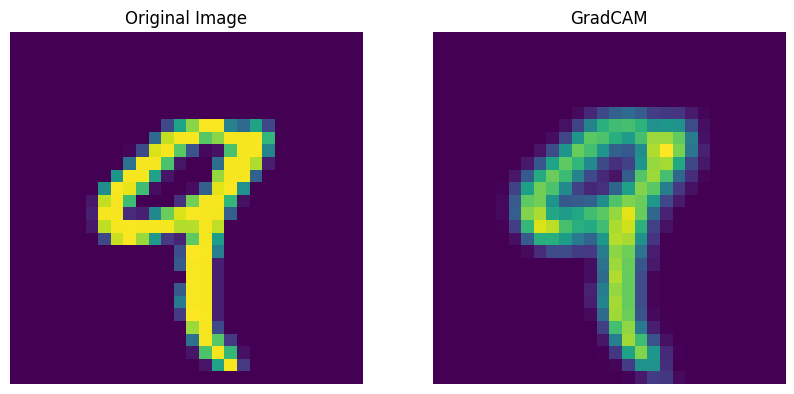

Layer: 2
Action index: 9


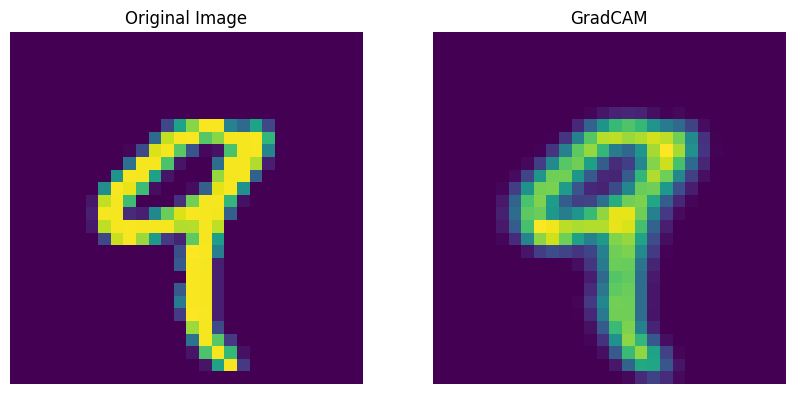

Layer: 3
Action index: 9


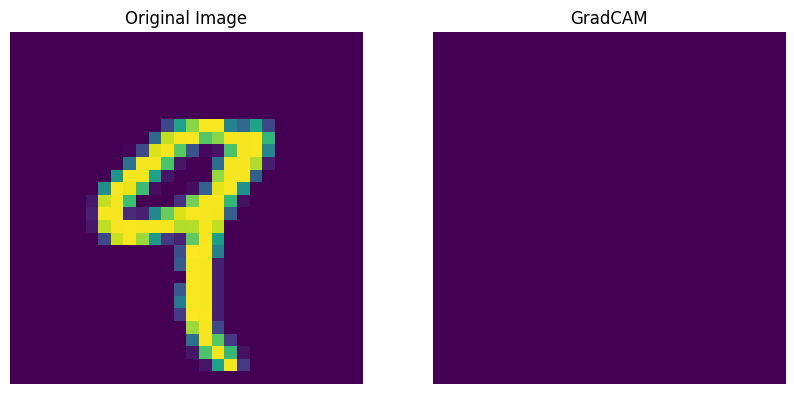

In [99]:
path = "C:/Projects/public/XAI_Master/models/mnistSimpleModel_1d.pth"

mnistSimpleModel.eval()
with torch.no_grad():
    test_outputs = mnistSimpleModel(x_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100
    print(f"Test Accuracy: {accuracy:.4f}%")

mnistSimpleModel.load_state_dict(torch.load(path))
mnistSimpleModel.eval()
print(f"Model loaded: {path}")

dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

layers = (mnistSimpleModel.conv1, mnistSimpleModel.conv2, mnistSimpleModel.conv3)

for layer, counter in zip(layers, range(len(layers))):
    print(f"Layer: {counter+1}")

    state = dataloader.dataset[4][0].unsqueeze(0) # Change picture here
    actions = mnistSimpleModel(state)
    target_layer = mnistSimpleModel.conv3
    target_layer = layer
    action_idx = torch.argmax(actions, dim=1).item()
    targets = [ClassifierOutputTarget(action_idx)]
    print(f"Action index: {action_idx}")


    with GradCAM(model=mnistSimpleModel, target_layers=[target_layer]) as cam:
        # Generate the CAM
        grayscale_cam = cam(input_tensor=state, targets=targets)
        grayscale_cam = grayscale_cam[0, :]#only one image in the batch
        original_img = state[0].permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, interpolation='nearest')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_cam, interpolation=None)
    plt.title("GradCAM")
    plt.axis('off')
    plt.show()


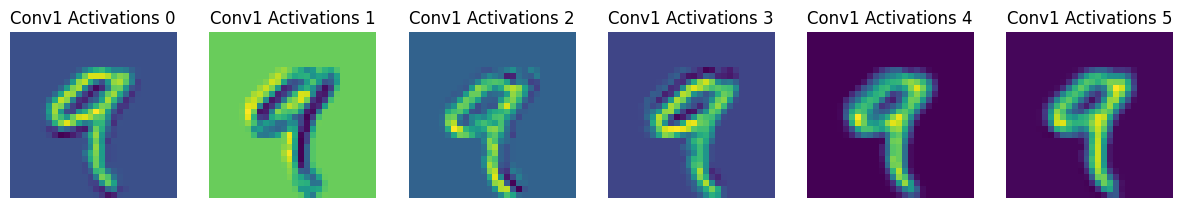

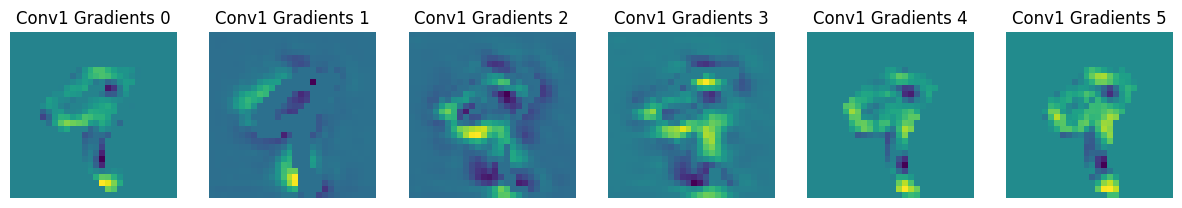

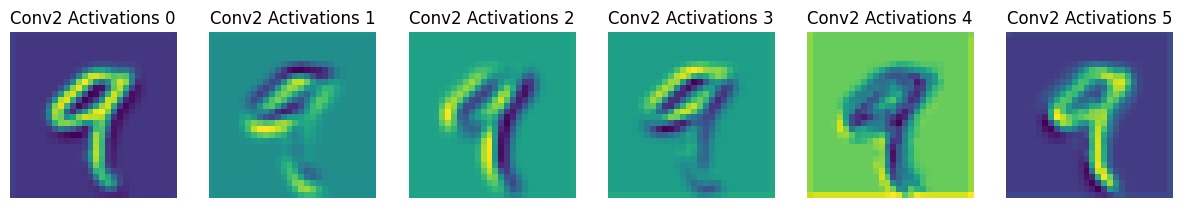

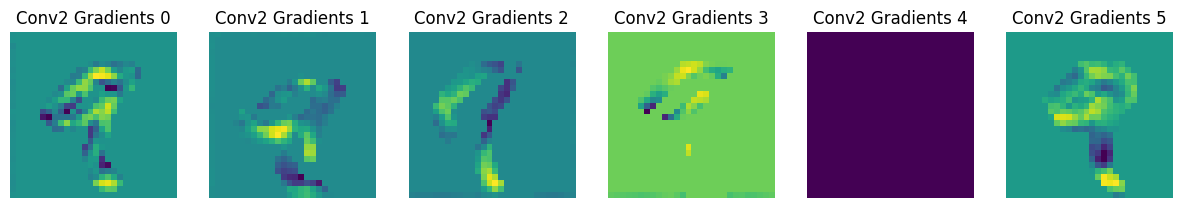

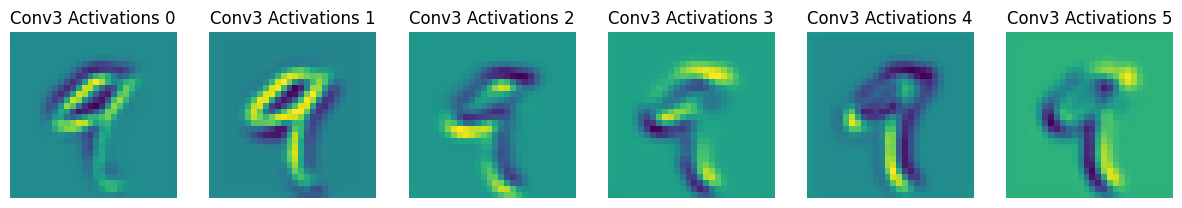

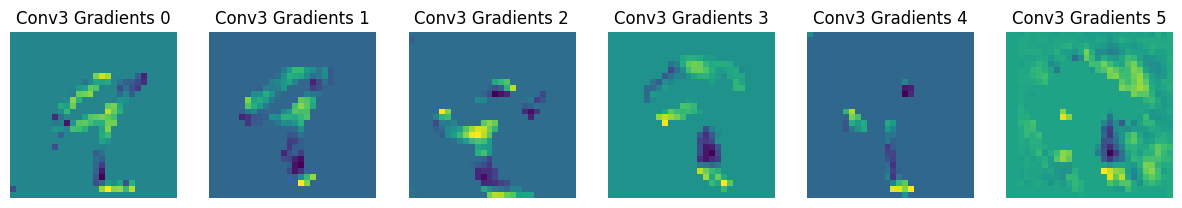

Predicted class: 9


In [100]:
# Containers for storing activations and gradients
activations = {}
gradients = {}

# Hook functions
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

def get_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach().cpu()
    return hook

# Pick a sample
state = dataloader.dataset[4][0].unsqueeze(0)  # Shape: [1, 1, 28, 28]

# Register hooks on all conv layers# Register hooks first
hooks = []
hooks.append(mnistSimpleModel.conv1.register_forward_hook(get_activation('conv1')))
hooks.append(mnistSimpleModel.conv1.register_backward_hook(get_gradient('conv1')))
hooks.append(mnistSimpleModel.conv2.register_forward_hook(get_activation('conv2')))
hooks.append(mnistSimpleModel.conv2.register_backward_hook(get_gradient('conv2')))
hooks.append(mnistSimpleModel.conv3.register_forward_hook(get_activation('conv3')))
hooks.append(mnistSimpleModel.conv3.register_backward_hook(get_gradient('conv3')))

# Set model to eval
mnistSimpleModel.eval()

# Pick one image
input_image = dataloader.dataset[4][0].unsqueeze(0)
input_image.requires_grad_()

# Forward pass
output = mnistSimpleModel(input_image)
predicted_class = output.argmax(dim=1).item()

# Backward pass
mnistSimpleModel.zero_grad()
output[0, predicted_class].backward()

def plot_feature_maps(tensor, title, num_maps=6):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_maps, tensor.shape[1])):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(tensor[0, i], cmap='viridis')
        plt.axis('off')
        plt.title(f"{title} {i}")
    plt.show()

plot_feature_maps(activations['conv1'], "Conv1 Activations")
plot_feature_maps(gradients['conv1'], "Conv1 Gradients")

plot_feature_maps(activations['conv2'], "Conv2 Activations")
plot_feature_maps(gradients['conv2'], "Conv2 Gradients")

plot_feature_maps(activations['conv3'], "Conv3 Activations")
plot_feature_maps(gradients['conv3'], "Conv3 Gradients")


# Clean up
for h in hooks:
    h.remove()


# Forward pass
state.requires_grad_()  # Required for gradients
output = mnistSimpleModel(state)
predicted_class = output.argmax(dim=1)
print(f"Predicted class: {predicted_class.item()}")

# Backward pass (for gradients)
mnistSimpleModel.zero_grad()
output[0, predicted_class].backward()



# Clean up hooks
for hook in hooks:
    hook.remove()


In [101]:
state_init, _ = env.reset()

Model loaded: C:/Projects/public/XAI_Master/models/y_r10_g02_3000k.pth
Layer: 1
Action: Down


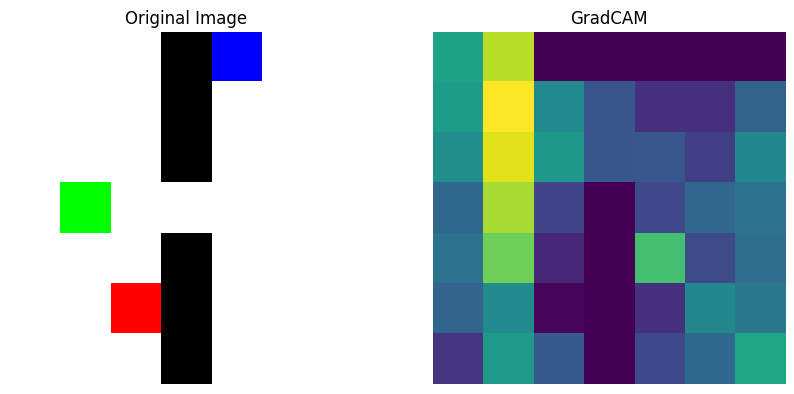

Layer: 2
Action: Down


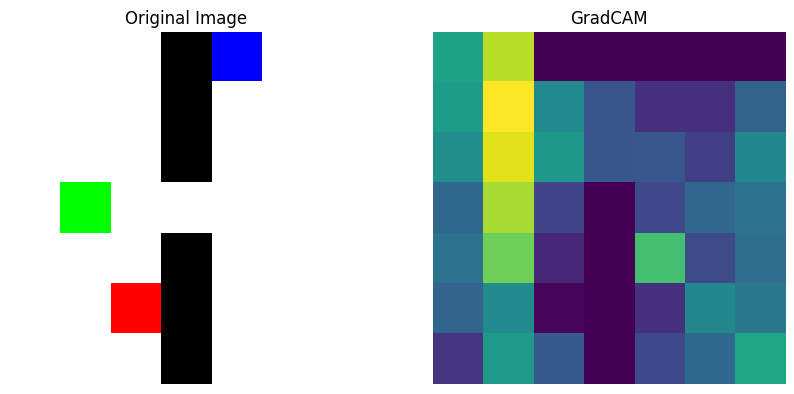

Layer: 3
Action: Down


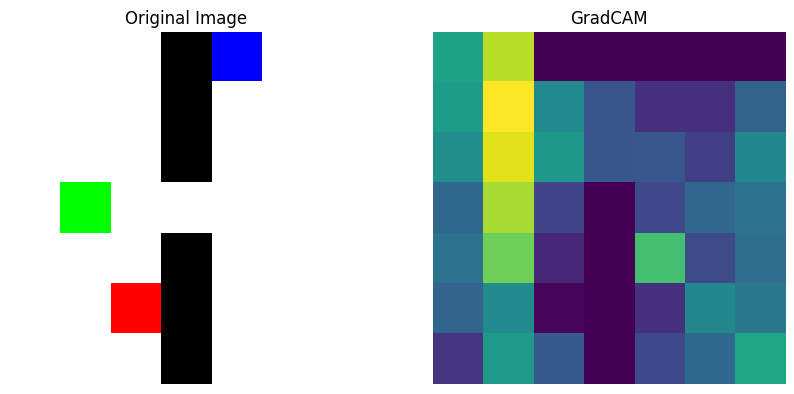

In [102]:
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/y_r10_g02_3000k.pth")

action_to_direction = {0: 'Right', 1: 'Down', 2: 'Left', 3: 'Up'}

state = torch.tensor(state_init, dtype=torch.float32, device=agent.device).unsqueeze(0)
actions = agent.predict(state)

layers = (agent.policy_net.conv1, agent.policy_net.conv2, agent.policy_net.conv3)
for layer, counter in zip(layers, range(len(layers))):
    print(f"Layer: {counter+1}")

    target_layer = agent.policy_net.conv3
    action_idx = torch.argmax(actions, dim=1).item()
    targets = [ClassifierOutputTarget(action_idx)]
    print(f"Action: {action_to_direction[action_idx]}")

    with GradCAM(model=agent.policy_net, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=state, targets=targets)
        grayscale_cam = grayscale_cam[0, :]#only one image in the batch
        original_img = state[0].permute(2, 1, 0).cpu().numpy()
        grayscale_cam = grayscale_cam.transpose(1, 0)

        # You can also get the model outputs without redoing inference
        #model_outputs = cam.outputs
        #print(f"Model outputs: {model_outputs}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, interpolation='nearest')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_cam, interpolation=None)
    plt.title("GradCAM")
    plt.axis('off')
    plt.show()

    #print(grayscale_cam)

Original image


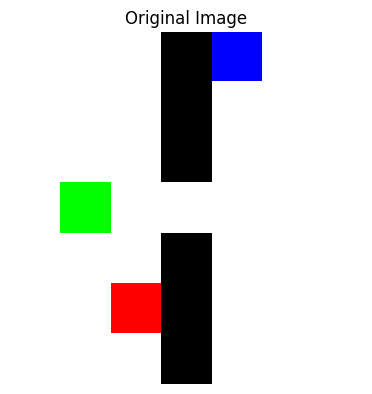

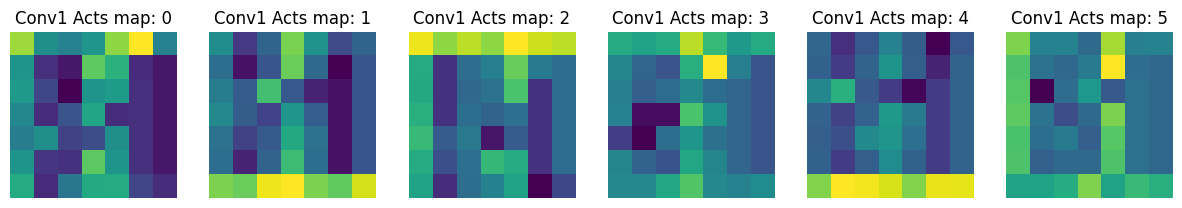

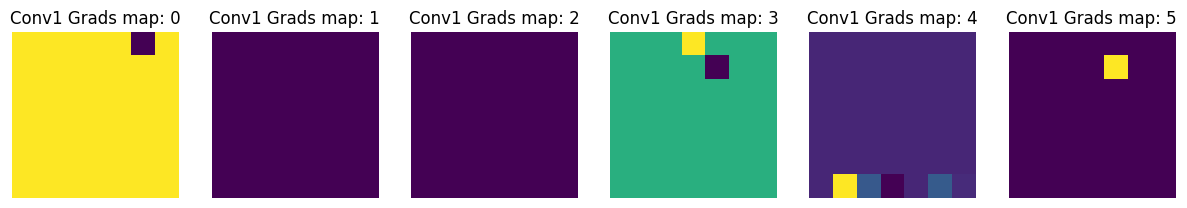

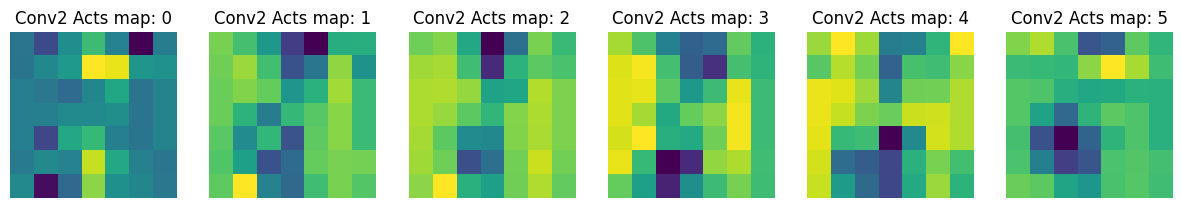

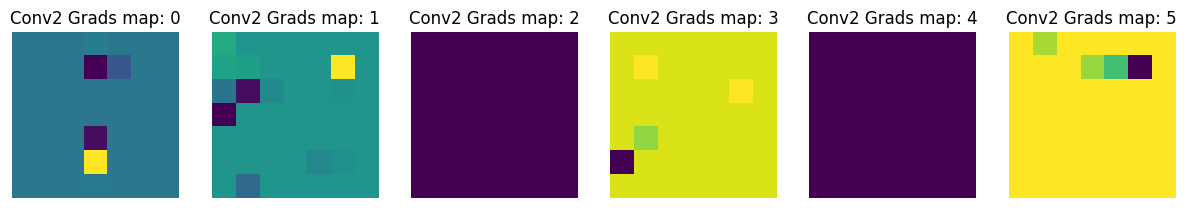

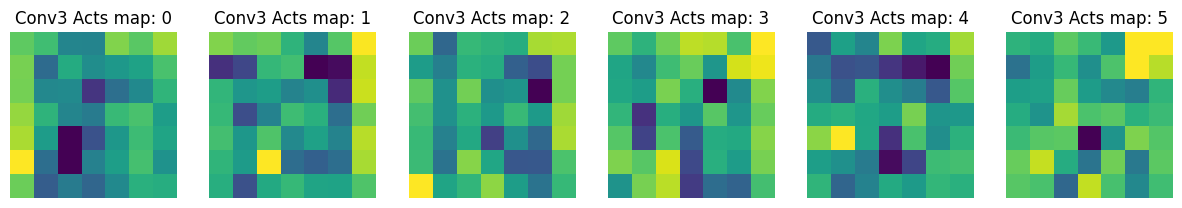

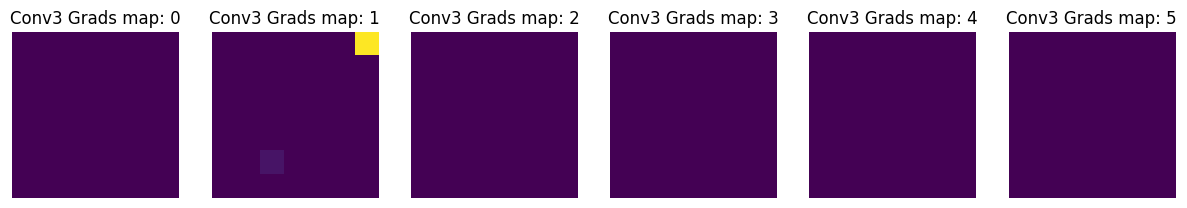

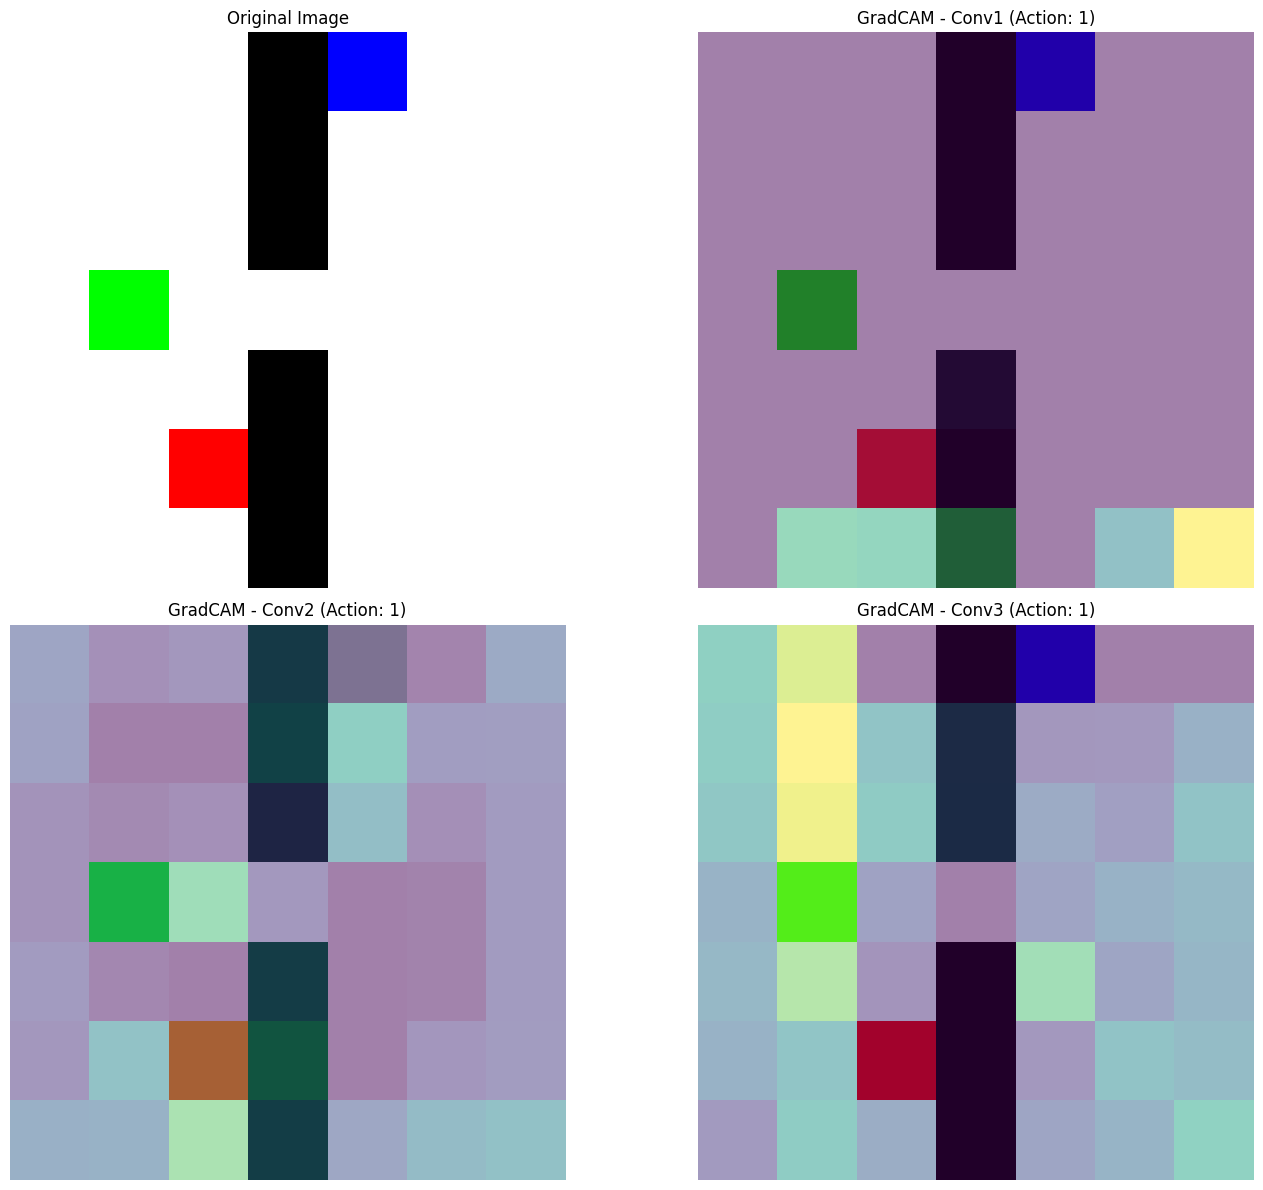

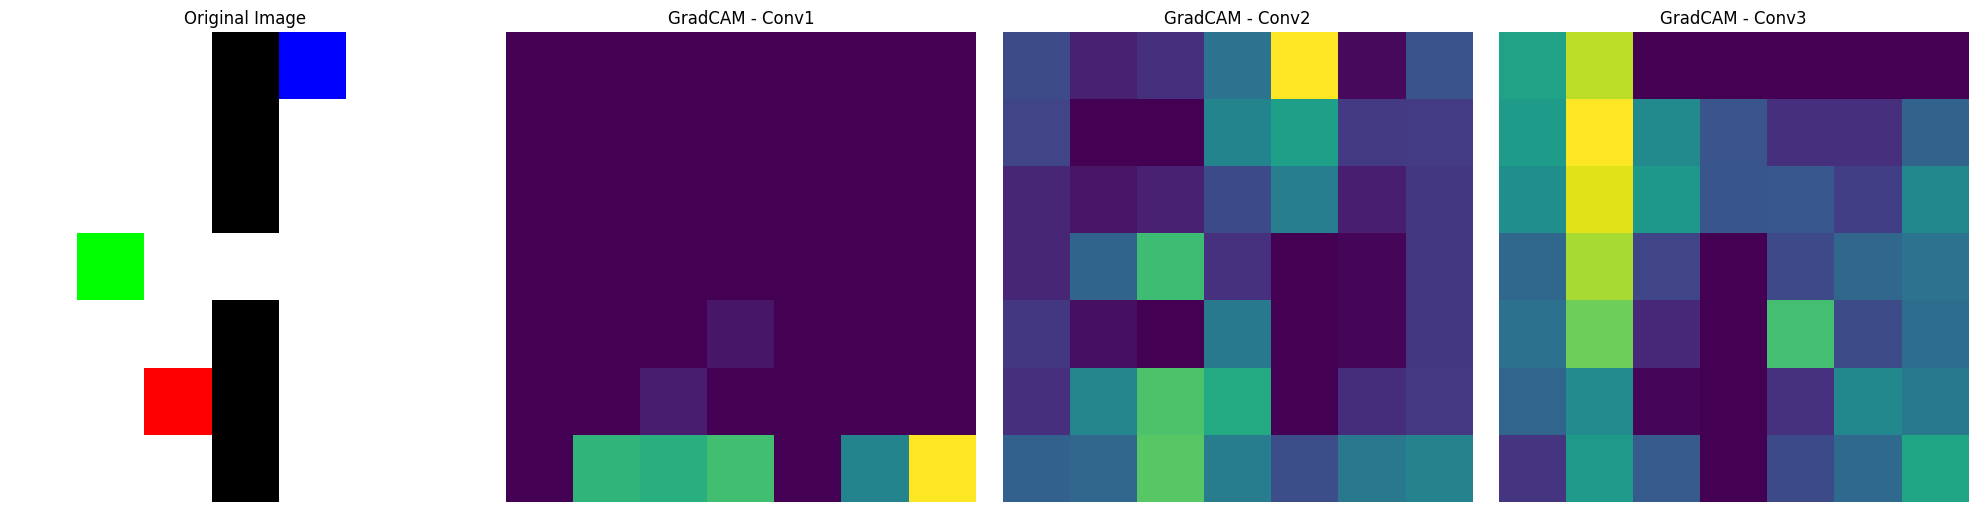

In [103]:
print("Original image")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img, interpolation='nearest')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Containers for storing activations and gradients
activations = {}
gradients = {}

# Hook functions
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

def get_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach().cpu()
    return hook

# game state
state = torch.tensor(state_init, dtype=torch.float32, device=agent.device).unsqueeze(0)

# Register hooks on all conv layers# Register hooks first
hooks = []
hooks.append(agent.policy_net.conv1.register_forward_hook(get_activation('conv1')))
hooks.append(agent.policy_net.conv1.register_backward_hook(get_gradient('conv1')))
hooks.append(agent.policy_net.conv2.register_forward_hook(get_activation('conv2')))
hooks.append(agent.policy_net.conv2.register_backward_hook(get_gradient('conv2')))
hooks.append(agent.policy_net.conv3.register_forward_hook(get_activation('conv3')))
hooks.append(agent.policy_net.conv3.register_backward_hook(get_gradient('conv3')))

# Set model to eval
agent.policy_net.eval()

# Pick one image
input_image = state
input_image.requires_grad_()

# Forward pass
output = agent.policy_net(input_image)
predicted_class = output.argmax(dim=1).item()

# Backward pass
agent.policy_net.zero_grad()
output[0, predicted_class].backward()

def plot_feature_maps(tensor, title, num_maps=6, transform=True):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_maps, tensor.shape[1])):
        if transform:
            tensor_i = tensor[0, i].clone().cpu().numpy().transpose(1, 0)
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(tensor_i, cmap='viridis')
        plt.axis('off')
        plt.title(f"{title} map: {i}")
    plt.show()

plot_feature_maps(activations['conv1'], "Conv1 Acts")
plot_feature_maps(gradients['conv1'], "Conv1 Grads")

plot_feature_maps(activations['conv2'], "Conv2 Acts")
plot_feature_maps(gradients['conv2'], "Conv2 Grads")

plot_feature_maps(activations['conv3'], "Conv3 Acts")
plot_feature_maps(gradients['conv3'], "Conv3 Grads")

printed = []

# Function to compute GradCAM for any layer
def compute_gradcam(activations, gradients, layer_name):
    # Get activations and gradients for the specified layer
    activation = activations[layer_name]
    gradient = gradients[layer_name]
    
    # Global average pooling of gradients
    weights = gradient.mean(dim=(2, 3), keepdim=True)
    
    # Weighted, linear combination of forward activation maps
    gradcam = (weights * activation).sum(dim=1, keepdim=True)
    
    # ReLU
    gradcam = F.relu(gradcam)
    
    # Normalize for visualization
    if gradcam.max() > 0:
        gradcam = gradcam / gradcam.max()
    
    # Resize to input dimensions
    gradcam = F.interpolate(
        gradcam, 
        size=input_image.shape[2:],
        mode='bilinear', 
        align_corners=False
    )
    
    return gradcam[0, 0].detach().cpu().numpy()

# Compute GradCAM for each layer
gradcam_conv1 = compute_gradcam(activations, gradients, 'conv1').transpose(1, 0)
gradcam_conv2 = compute_gradcam(activations, gradients, 'conv2').transpose(1, 0)
gradcam_conv3 = compute_gradcam(activations, gradients, 'conv3').transpose(1, 0)

# Display GradCAM for each layer alongside the original image
plt.figure(figsize=(15, 12))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(original_img, interpolation='nearest')
plt.title("Original Image")
plt.axis('off')

# GradCAM for conv1
plt.subplot(2, 2, 2)
plt.imshow(original_img, interpolation='nearest')
plt.imshow(gradcam_conv1, cmap='viridis', alpha=0.5)
plt.title(f"GradCAM - Conv1 (Action: {predicted_class})")
plt.axis('off')

# GradCAM for conv2
plt.subplot(2, 2, 3)
plt.imshow(original_img, interpolation='nearest')
plt.imshow(gradcam_conv2, cmap='viridis', alpha=0.5)
plt.title(f"GradCAM - Conv2 (Action: {predicted_class})")
plt.axis('off')

# GradCAM for conv3
plt.subplot(2, 2, 4)
plt.imshow(original_img, interpolation='nearest')
plt.imshow(gradcam_conv3, cmap='viridis', alpha=0.5)
plt.title(f"GradCAM - Conv3 (Action: {predicted_class})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Create a side-by-side comparison of all GradCAM visualizations
plt.figure(figsize=(20, 5))

# GradCAM for conv1
plt.subplot(1, 4, 1)
plt.imshow(original_img, interpolation='nearest')
plt.title("Original Image")
plt.axis('off')

# GradCAM for conv1
plt.subplot(1, 4, 2)
plt.imshow(gradcam_conv1, cmap='viridis')
plt.title(f"GradCAM - Conv1")
plt.axis('off')

# GradCAM for conv2
plt.subplot(1, 4, 3)
plt.imshow(gradcam_conv2, cmap='viridis')
plt.title(f"GradCAM - Conv2")
plt.axis('off')

# GradCAM for conv3
plt.subplot(1, 4, 4)
plt.imshow(gradcam_conv3, cmap='viridis')
plt.title(f"GradCAM - Conv3")
plt.axis('off')

plt.tight_layout()
plt.show()

# Clean up
for h in hooks:
    h.remove()

